# Bear Classifier

## Create dataset

Create our own dataset using google images and classify between teddy bear,
grizzly bear and black bear using Pytorch and fastai.

In this notebook we are creating our own dataset of teddy bear, black bear and grizzly bear and try to classify between them.

Import the drive if you're using Google Colab.
Go to appeared URL in a browser and enter your authorization code
If you are able to access [Google Drive](https://drive.google.com),
your google drive files should be all under:
`Files -> /content/drive/My Drive/`

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


[Install fastai](https://github.com/foobar167/junkyard/tree/master/object_classifier/#step-1)
library for your local computer **with modern GPU** if necessary or continue to run this notebook via Google Colab.

In [0]:
# Import the required packages
# The Pathlib module is available from Python >= 3.4
import shutil
from pathlib import Path
from fastai.vision import *
from fastai.metrics import error_rate

In [3]:
# Remove previous directories and files,
# otherwise there could be problems with images download
#!rm -f -r '/content/drive/My Drive/bear_dataset'
#!rm *.txt

# Set path to the dataset
path = Path('/content/drive/My Drive/bear_dataset')

# Set path for your local system
# path = Path('d:/Data/Testing/bear_dataset')

# Create directories
black = path / 'black'
black.mkdir(parents=True, exist_ok=True)

grizzly = path / 'grizzly'
grizzly.mkdir(parents=True, exist_ok=True)

teddy = path / 'teddy'
teddy.mkdir(parents=True, exist_ok=True)

urls = path / 'urls'
urls.mkdir(parents=True, exist_ok=True)

rm: cannot remove '*.txt': No such file or directory


In [0]:
# Upload 3 files with URLs from 'urls' directory
# Run this cell several times if it fail 1st time.
from google.colab import files
files.upload()  # this will prompt you to upload the files

In [8]:
# Copy uploaded files to 'urls' directory
shutil.copy('blackbear.txt', str(urls))
shutil.copy('grizzlybear.txt', str(urls))
shutil.copy('teddybear.txt', str(urls))

'/content/drive/My Drive/bear_dataset/urls/teddybear.txt'

In [0]:
# Download images
download_images(urls/'blackbear.txt', black, max_pics = 500)
download_images(urls/'grizzlybear.txt', grizzly, max_pics = 500)
download_images(urls/'teddybear.txt', teddy, max_pics = 500)

In [0]:
# Verify and delete corrupted images
# Resize image to (width or height) max_size 500 pixels
for bear in (black, grizzly, teddy):
    verify_images(bear, delete=True, max_size=500)

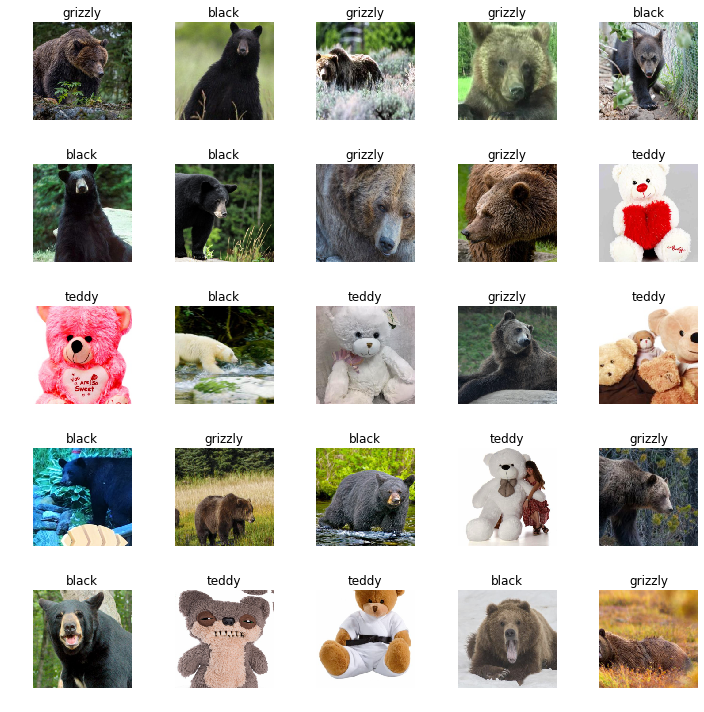

In [54]:
# Normalize data
data = ImageDataBunch.from_folder(
    path, train='.', valid_pct=0.2, seed=42,
    ds_tfms=get_transforms(), size=224).normalize(imagenet_stats)

# View data
data.show_batch(rows=5, figsize=(10, 10))

In [55]:
print(data.classes)
print(len(data.train_ds))
print(len(data.valid_ds))

['black', 'grizzly', 'teddy']
725
181


## Training
Use [vision.learner](https://docs.fast.ai/vision.learner.html) module
of the **fastai** library which defines the
[cnn_learner](https://docs.fast.ai/vision.learner.html#cnn_learner) and
[unet_learner](https://docs.fast.ai/vision.learner.html#unet_learner)
methods to easily get a model suitable for transfer learning.

View [basic training functionality](https://docs.fast.ai/basic_train.html)
documentation for more information.

In [0]:
# Create CNN learner model
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

In [74]:
# Launch a training using the 1-cycle policy
# to help you train your model faster.
# Retrain (transfer learning) on 6 epochs.
learn.fit_one_cycle(6)

epoch,train_loss,valid_loss,error_rate,time
0,1.054451,0.160095,0.049724,00:12
1,0.591523,0.199896,0.027624,00:12
2,0.417623,0.174435,0.027624,00:12
3,0.313668,0.179806,0.033149,00:12
4,0.252348,0.164266,0.033149,00:12
5,0.210482,0.161172,0.033149,00:12


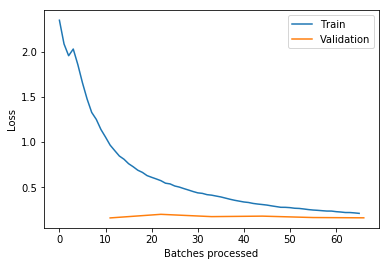

In [75]:
# Show losses
learn.recorder.plot_losses()

In [76]:
# Save the model PTH file into 'path/models' directory
p = learn.save('bears_trained_model-1', return_path=True)
print(p)

/content/drive/My Drive/bear_dataset/models/bears_trained_model-1.pth


In [0]:
# Unfreeze entire model. All layers now trainable.
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


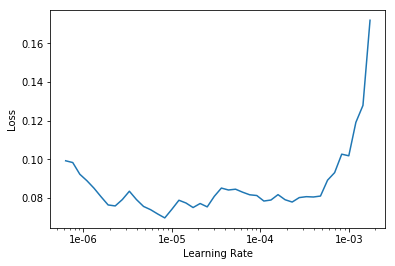

In [78]:
# Launch an LR range test (model fitting method)
# that will help you select a good learning rate.
learn.lr_find()
learn.recorder.plot()

The [learning rate](https://machinelearningmastery.com/understand-the-dynamics-of-learning-rate-on-deep-learning-neural-networks/)
is a configurable hyperparameter used in the training of neural networks
that has a small positive value, often in the range between 0.0 and 1.0.
The learning rate controls how quickly the model is adapted to the problem.

Smaller learning rates require more training epochs given the smaller changes
made to the weights each update, whereas larger learning rates result
in rapid changes and require fewer training epochs.

In [81]:
# Load previous model
learn.load('bears_trained_model-1')

# Fine-tune model using obtained learning rate
# in the range from 2 * 10^(-6) upto 4 * 10^(-4).
learn.fit_one_cycle(2, max_lr=slice(2e-06, 4e-04))

epoch,train_loss,valid_loss,error_rate,time
0,0.083908,0.163860,0.027624,00:12
1,0.086590,0.157482,0.027624,00:12


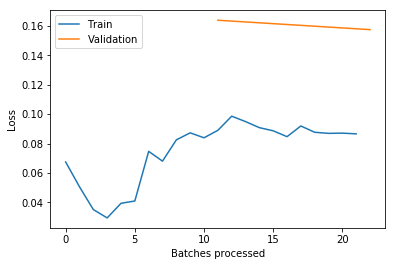

In [82]:
# Show losses
learn.recorder.plot_losses()

If fine-tune doesn't help much use `bears_trained_model-1`,
otherwise use `bears_trained_model-2`.

In [83]:
learn.save('bears_trained_model-2', return_path=True)

PosixPath('/content/drive/My Drive/bear_dataset/models/bears_trained_model-2.pth')

## Interpretation

In [0]:
# Load previous model
output = learn.load('bears_trained_model-2')
print(output)

Class [ClassificationInterpretation](https://docs.fast.ai/vision.learner.html#ClassificationInterpretation)
provides a confusion matrix and visualization of the most incorrect images.

In [0]:
interp = ClassificationInterpretation.from_learner(learn)

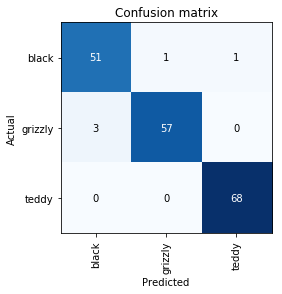

In [88]:
interp.plot_confusion_matrix()

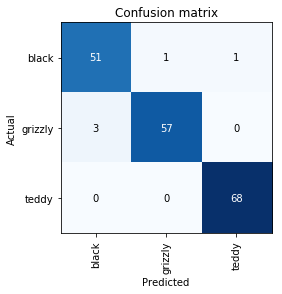

In [89]:
# You can also use a shortcut learn.interpret() to do the same
interp2 = learn.interpret()
interp2.plot_confusion_matrix()

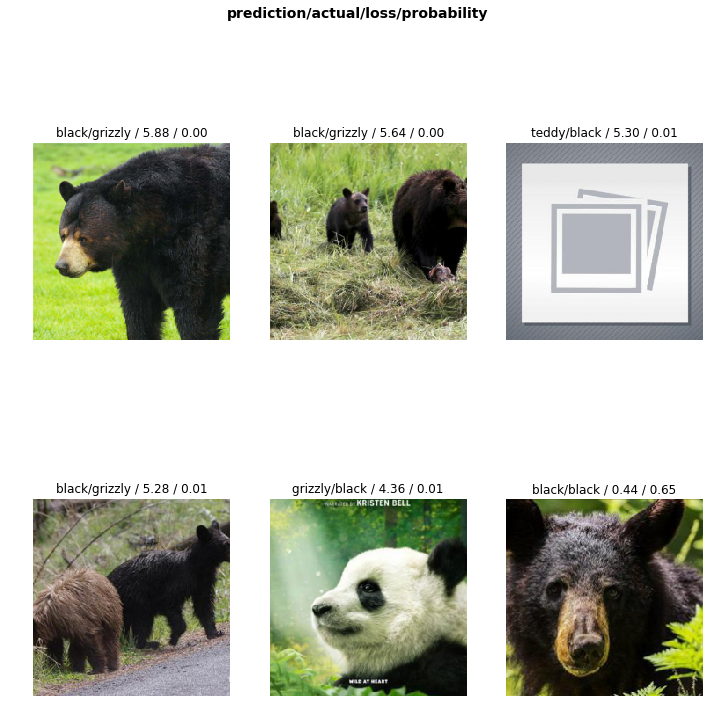

In [90]:
interp.plot_top_losses(k=6, heatmap=False)

## Prediction

In [0]:
defaults.device = torch.device('cpu')

[Export](https://docs.fast.ai/basic_train.html#Learner.export)
the state of the Learner in `path/export.pkl` file by default.

In [0]:
trained_model = 'bears_trained_model.pkl'
learn.export(file='bears_trained_model.pkl')

[Image](https://docs.fast.ai/vision.image.html#Image)
is the class that wraps every picture in the **fastai** library.

[open_image](https://docs.fast.ai/vision.image.html#open_image)
method return Image object created from image by filename.

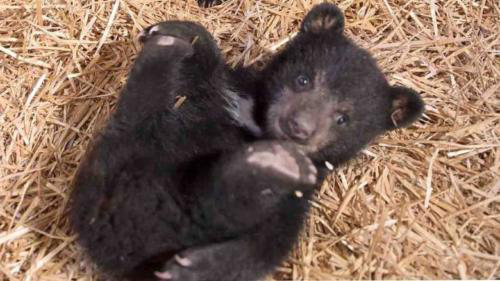

In [93]:
# Example image
img = open_image(path/'black/00000066.jpeg')
img

In [0]:
# Load a Learner object saved with export
learn = load_learner(path=path, file=trained_model)

In [95]:
predict, idx, outputs = learn.predict(img)
print('Predicted class:', predict)

Predicted class: black


In [0]:
# Go to your Google Drive (https://drive.google.com)
# and download Pickle file with trained model
# "bears_trained_model.pkl"

# Remove data to free drive space
#!rm -f -r '/content/drive/My Drive/bear_dataset'
#!rm *.txt